### Test models to know how to extract activations 

### TODO : cf overleaf for a list of models to test.

In [1]:
import os
import json
import urllib.request

base_dir = "/datasets/shared_datasets/fashion_iq"
os.makedirs(base_dir, exist_ok=True)

def download_file(url, dest):
    if not os.path.exists(dest):
        urllib.request.urlretrieve(url, dest)

# ---------- 1. Captions ----------
caption_types = ["dress", "shirt", "toptee"]
splits = ["train", "val", "test"]

for ctype in caption_types:
    for split in splits:
        url = f"https://raw.githubusercontent.com/XiaoxiaoGuo/fashion-iq/master/captions/cap.{ctype}.{split}.json"
        dest = f"{base_dir}/captions/cap.{ctype}.{split}.json"
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        download_file(url, dest)

# ---------- 2. Image Splits ----------
for ctype in caption_types:
    for split in splits:
        url = f"https://raw.githubusercontent.com/XiaoxiaoGuo/fashion-iq/master/image_splits/split.{ctype}.{split}.json"
        dest = f"{base_dir}/image_splits/split.{ctype}.{split}.json"
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        download_file(url, dest)

# ---------- 3. Image URLs ----------
for ctype in caption_types:
    url = f"https://raw.githubusercontent.com/hongwang600/fashion-iq-metadata/master/image_url/asin2url.{ctype}.txt"
    dest = f"{base_dir}/image_url/asin2url.{ctype}.txt"
    os.makedirs(os.path.dirname(dest), exist_ok=True)
    download_file(url, dest)

# ---------- 4. Broken Link Placeholders ----------
# Broken image placeholders
placeholder_list = [
    "B008583YKC.jpg",  # add others if needed
]

for fname in placeholder_list:
    url = f"https://raw.githubusercontent.com/hongwang600/fashion-iq-metadata/master/image_url/broken_links/{fname}"
    dest = f"{base_dir}/image_url/broken_links/{fname}"
    os.makedirs(os.path.dirname(dest), exist_ok=True)
    download_file(url, dest)


In [1]:
import os
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
import seaborn as sns
from transformers import CLIPModel, CLIPProcessor, SiglipModel, SiglipProcessor, AutoProcessor, AutoModel, AutoModelForZeroShotImageClassification

device = "cuda:1" if torch.cuda.is_available() else "cpu"

In [3]:
model_name="openai/clip-vit-large-patch14"
base_path = "./imagenet/embeddings/" + model_name

os.makedirs(base_path, exist_ok=True)

In [7]:
import torch
import torch.nn.functional as F
from urllib.request import urlopen
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-L-16-SigLIP-384')
tokenizer = get_tokenizer('hf-hub:timm/ViT-L-16-SigLIP-384')

image = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))
image = preprocess(image).unsqueeze(0)

labels_list = ["a dog", "a cat", "a donut", "a beignet"]
text = tokenizer(labels_list, context_length=model.context_length)

with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)

    text_probs = torch.sigmoid(image_features @ text_features.T * model.logit_scale.exp() + model.logit_bias)

zipped_list = list(zip(labels_list, [round(p.item(), 3) for p in text_probs[0]]))
print("Label probabilities: ", zipped_list)

open_clip_model.safetensors:   0%|          | 0.00/2.61G [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/888 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

/tmp/ipykernel_2008385/1024763530.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Label probabilities:  [('a dog', 0.0), ('a cat', 0.0), ('a donut', 0.0), ('a beignet', 0.409)]


In [7]:
clip_name = "openai/clip-vit-large-patch14"
siglip_name = "google/siglip-base-patch16-224"
siglip2_name = "google/siglip2-base-patch16-224"
openclip_name="laion/CLIP-ViT-L-14-laion2B-s32B-b82K"
clipa_name = "UCSC-VLAA/ViT-L-14-CLIPA-datacomp1B"

# clip_model = CLIPModel.from_pretrained(clip_name).to(device)
# clip_processor = CLIPProcessor.from_pretrained(clip_name)
# clip_model.eval()

clipa_model = CLIPModel.from_pretrained(clipa_name).to(device)
clipa_processor = CLIPProcessor.from_pretrained(clipa_name)
clipa_model.eval()

# openclip_model = CLIPModel.from_pretrained(clip_name).to(device)
# openclip_processor = CLIPProcessor.from_pretrained(clip_name)
# openclip_model.eval()

# siglip_model = SiglipModel.from_pretrained(siglip_name).to(device)
# siglip_processor = SiglipProcessor.from_pretrained(siglip_name)
# siglip_model.eval()

# siglip2_model = AutoModel.from_pretrained(siglip2_name).to(device)
# siglip2_processor = AutoProcessor.from_pretrained(siglip2_name)
# siglip2_model.eval()

OSError: UCSC-VLAA/ViT-L-14-CLIPA-datacomp1B does not appear to have a file named pytorch_model.bin, model.safetensors, tf_model.h5, model.ckpt or flax_model.msgpack.

In [4]:
path_to_laion = "/datasets/shared_datasets/LAION400M/embeddings"

meta = pd.read_parquet(path_to_laion + "/CLIP/metadata/metadata_0.parquet")

In [5]:
print(meta.shape)
print(meta.columns)
print(meta.head())

# extract 'image_path' column
image_paths = meta['image_path'].tolist()
print(image_paths[:5])
# extract 'caption' column and 'url' column
captions = meta['caption'].tolist()
urls = meta['url'].tolist()
print(captions[:5])
print(urls[:5])

(1000448, 15)
Index(['image_path', 'caption', 'NSFW', 'similarity', 'LICENSE', 'url', 'key',
       'shard_id', 'status', 'error_message', 'width', 'height', 'exif',
       'original_width', 'original_height'],
      dtype='object')
  image_path                                            caption      NSFW  \
0  000000033  2 bed Terraced property to rent in Crofts Lane...  UNLIKELY   
1  000000044  Teleflora's Simply Sweet in Cleveland TN, Jimm...  UNLIKELY   
2  000000052  Happy little girl  on the meadow - Stock fotog...  UNLIKELY   
3  000000015                                   Purple Forest...  UNLIKELY   
4  000000043                   Seamless metal background vector  UNLIKELY   

   similarity LICENSE                                                url  key  \
0    0.333244       ?  http://media.rightmove.co.uk/dir/87k/86030/419...   33   
1    0.301415       ?  http://images.shopflowers.net/images/products/...   44   
2    0.332064       ?  http://static9.depositphotos.com/10406

In [6]:
# Download images
num_images = 10
downloaded = []


texts = "a photo of 2 cats"
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
img = Image.open(requests.get(url, stream=True).raw)

downloaded.append((img, texts))

for idx, row in meta.iterrows():
    url = row['url']
    caption = row['caption']
    
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGB")
        downloaded.append((img, caption))
        if len(downloaded) >= num_images:
            break
    except Exception as e:
        print(f"Skipping {url}: {e}")

Skipping http://images.shopflowers.net/images/products/HW0_372712.jpg: HTTPConnectionPool(host='images.shopflowers.net', port=80): Read timed out. (read timeout=5)


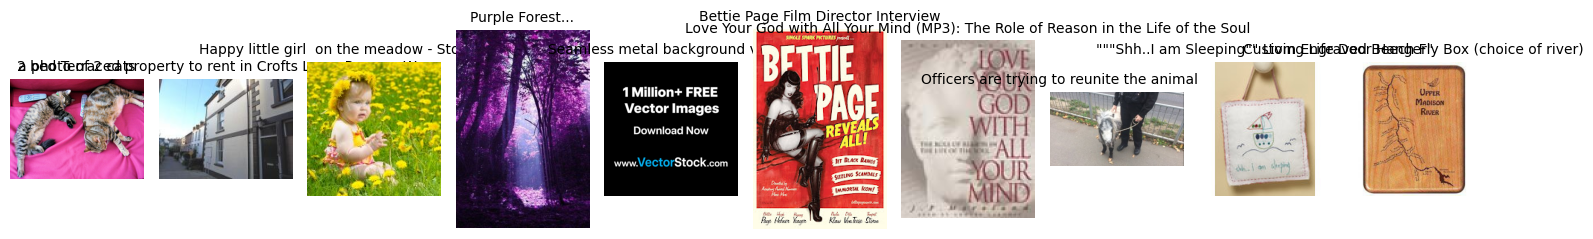

In [7]:
# Display images with captions
fig, axes = plt.subplots(1, len(downloaded), figsize=(15, 5))
for ax, (img, caption) in zip(axes, downloaded):
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(caption[:100], fontsize=10)
plt.tight_layout()
plt.show()


In [8]:
for t in [t for _, t in downloaded]:
    print(t)

a photo of 2 cats
2 bed Terraced property to rent in Crofts Lane, Ross-on-Wye
Happy little girl  on the meadow - Stock fotografie
Purple Forest...
Seamless metal background vector
Bettie Page Film Director Interview
Love Your God with All Your Mind (MP3): The Role of Reason in the Life of the Soul
Officers are trying to reunite the animal with its owners.
"""Shh..I am Sleeping"" Living Life Door Hanger"
Custom Engraved Beech Fly Box (choice of river)


In [35]:
import inspect
print(inspect.getsource(clip_model.forward))

    @can_return_tuple
    @add_start_docstrings_to_model_forward(CLIP_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=CLIPOutput, config_class=CLIPConfig)
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        pixel_values: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        return_loss: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        interpolate_pos_encoding: bool = False,
    ) -> CLIPOutput:
        r"""
        Returns:

        Examples:

        ```python
        >>> from PIL import Image
        >>> import requests
        >>> from transformers import AutoProcessor, CLIPModel

        >>> model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        >>> processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

   

In [9]:
# Helper function
@torch.no_grad()
def get_features(model, processor, images, captions, max_length):
    # padding = "max_length" if isinstance(model, SiglipModel) else "longest"
    tokenizer = lambda texts: processor(text=texts, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length)
    preprocess = lambda img: processor(images=img, return_tensors="pt")['pixel_values']
    
    image_tensor = preprocess(images).to(device)
    text_tokens = tokenizer(captions).to(device)
    
    img_feat = model.get_image_features(pixel_values=image_tensor)
    img_feat /= img_feat.norm(dim=-1, keepdim=True)
    txt_feat = model.get_text_features(**text_tokens)
    txt_feat /= txt_feat.norm(dim=-1, keepdim=True)
    
    return img_feat, txt_feat

# Extract features
images = [img for img, _ in downloaded]
captions = [cap for _, cap in downloaded]

# clip_i, clip_t = get_features(openclip_model, openclip_processor, images, captions, max_length=openclip_model.config.text_config.max_position_embeddings)
clip_i, clip_t = get_features(clip_model, clip_processor, images, captions, max_length=clip_model.config.text_config.max_position_embeddings)
# siglip_i, siglip_t = get_features(siglip_model, siglip_processor, images, captions, max_length=siglip_model.config.text_config.max_position_embeddings)
# siglip2_i, siglip2_t = get_features(siglip2_model, siglip2_processor, images, captions, max_length=siglip2_model.config.text_config.max_position_embeddings)

# Cosine similarity matrices
@torch.no_grad()
def plot_cosim(img_feat, txt_feat, title, model):
    cosim = img_feat @ txt_feat.T
    if isinstance(model, SiglipModel):
        logit_scale, logit_bias = model.logit_scale.to(txt_feat.device), model.logit_bias.to(txt_feat.device)
        logits_per_text = cosim * logit_scale.exp() + logit_bias
        probs = torch.sigmoid(logits_per_text)
    else:
        logits_per_text = cosim * model.logit_scale.exp().to(txt_feat.device)
        probs = F.softmax(logits_per_text, dim=-1)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.heatmap(cosim.cpu().numpy(), annot=True, fmt=".2f", cmap="viridis",
                xticklabels=False, yticklabels=False, ax=axes[0])
    axes[0].set_title(f"{title} - Cosine Similarity")
    axes[0].set_xlabel("Text")
    axes[0].set_ylabel("Image")

    sns.heatmap(probs.cpu().numpy(), annot=True, fmt=".2f", cmap="magma",
                xticklabels=False, yticklabels=False, ax=axes[1])
    axes[1].set_title(f"{title} - Probabilities")
    axes[1].set_xlabel("Text")
    axes[1].set_ylabel("Image")

    plt.tight_layout()
    plt.show()


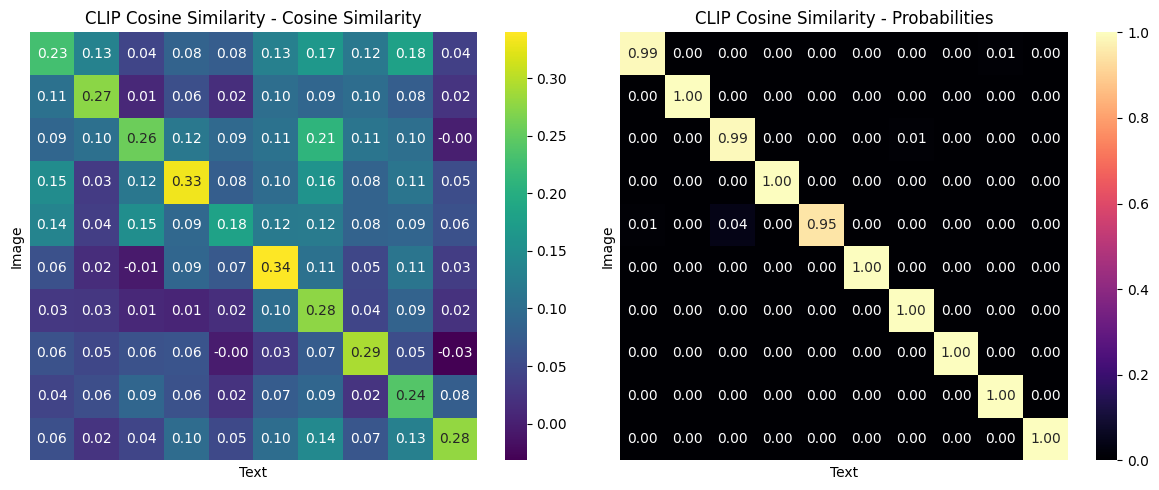

In [10]:
plot_cosim(clip_i, clip_t, "CLIP Cosine Similarity", model=clip_model)
# plot_cosim(clip_i, clip_t, "CLIP Cosine Similarity", model=clip_model)
# plot_cosim(siglip_i, siglip_t, "SigLIP Cosine Similarity", model=siglip_model)
# plot_cosim(siglip2_i, siglip2_t, "SigLIP2 Cosine Similarity", model=siglip2_model)

In [15]:
import torch
import torch.nn.functional as F
from urllib.request import urlopen
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8

model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-L-16-SigLIP-384')
tokenizer = get_tokenizer('hf-hub:timm/ViT-L-16-SigLIP-384')

image = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))
image = [preprocess(i).unsqueeze(0) for i in images]

labels_list = ["a dog", "a cat", "a donut", "a beignet"]
text = tokenizer(captions, context_length=model.context_length)

with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features = F.normalize(image_features, dim=-1)
    text_features = F.normalize(text_features, dim=-1)

    text_probs = torch.sigmoid(image_features @ text_features.T * model.logit_scale.exp() + model.logit_bias)

# zipped_list = list(zip(labels_list, [round(p.item(), 3) for p in text_probs[0]]))
# print("Label probabilities: ", zipped_list)

plt.imshow(text_probs.cpu().numpy(), cmap='viridis')
plt.colorbar()


/tmp/ipykernel_2008385/2155868015.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


AttributeError: 'list' object has no attribute 'shape'

In [9]:
import torch
from transformers import SiglipProcessor, SiglipModel
from PIL import Image

model = SiglipModel.from_pretrained("google/siglip-base-patch16-224")
processor = SiglipProcessor.from_pretrained("google/siglip-base-patch16-224")

image = Image.open("example.jpg")
inputs = processor(text=["A photo of a dog"], images=image, return_tensors="pt", padding=True)

with torch.no_grad():
    outputs = model(**inputs)
    image_embeds = outputs.image_embeds / outputs.image_embeds.norm(dim=-1, keepdim=True)
    text_embeds = outputs.text_embeds / outputs.text_embeds.norm(dim=-1, keepdim=True)
    similarity = (image_embeds @ text_embeds.T).item()

print(f"Cosine similarity: {similarity:.4f}")
print(outputs.keys())
print(outputs["logits_per_image"])

Cosine similarity: -0.0533
odict_keys(['logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])
tensor([[-19.1825]])


In [14]:
from transformers import SiglipProcessor, SiglipModel
from PIL import Image
import torch

model = SiglipModel.from_pretrained("google/siglip-base-patch16-224")
processor = SiglipProcessor.from_pretrained("google/siglip-base-patch16-224")

image = Image.open("clip.png").convert("RGB")
inputs = processor(text=["A photo of a dog", "A diagram showing how CLIP connects image and text"], images=image, return_tensors="pt", padding=True)

with torch.no_grad():
    outputs = model(**inputs)

image_embeds = outputs.image_embeds / outputs.image_embeds.norm(dim=-1, keepdim=True)
text_embeds = outputs.text_embeds / outputs.text_embeds.norm(dim=-1, keepdim=True)

similarity = (image_embeds @ text_embeds.T)
print(f"Cosine similarity: {similarity}")


Cosine similarity: tensor([[-0.0132, -0.0003]])


In [27]:
from transformers import SiglipProcessor, SiglipModel
from PIL import Image
import torch, torch.nn.functional as F
import requests

model = SiglipModel.from_pretrained("google/siglip-base-patch16-224")
processor = SiglipProcessor.from_pretrained("google/siglip-base-patch16-224")
img = Image.open("clip.png").convert("RGB")
texts = ["a photo of 2 cats", "a photo of 2 dogs"]
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
img = Image.open(requests.get(url, stream=True).raw)
inp = processor(images=img, text=texts, return_tensors="pt", padding="max_length")

with torch.no_grad():
    out = model(**inp)
    ie = out.image_embeds; te = out.text_embeds
    ie = ie / ie.norm(dim=-1, keepdim=True)
    te = te / te.norm(dim=-1, keepdim=True)
    cos = (ie @ te.T)
    sig = F.sigmoid(out.logits_per_image)

print(f"Cosine similarity: {cos}")
print(f"Sigmoid matching score: {sig}")



Cosine similarity: tensor([[0.1038, 0.0221]])
Sigmoid matching score: tensor([[3.1937e-01, 3.2463e-05]])


In [26]:
print(inp)
print(inputs)

{'input_ids': tensor([[ 262,  266, 1304,  267,  454, 6473,    1],
        [ 262,  266, 1304,  267,  454, 3014,    1]]), 'pixel_values': tensor([[[[ 0.1137,  0.1686,  0.1922,  ..., -0.1922, -0.1843, -0.1922],
          [ 0.1373,  0.1686,  0.1843,  ..., -0.1922, -0.1922, -0.2078],
          [ 0.1137,  0.1529,  0.1608,  ..., -0.2392, -0.2235, -0.2078],
          ...,
          [ 0.8431,  0.7882,  0.7255,  ...,  0.7098,  0.6549,  0.6314],
          [ 0.8275,  0.7961,  0.7725,  ...,  0.6157,  0.4902,  0.4196],
          [ 0.8275,  0.7569,  0.7647,  ...,  0.0275, -0.1059, -0.2471]],

         [[-0.8118, -0.8118, -0.8118,  ..., -0.8902, -0.8902, -0.8980],
          [-0.7882, -0.7882, -0.7882,  ..., -0.8824, -0.8745, -0.8824],
          [-0.8196, -0.8039, -0.7882,  ..., -0.8980, -0.8902, -0.8902],
          ...,
          [-0.2627, -0.3255, -0.3725,  ..., -0.4196, -0.4510, -0.4745],
          [-0.2627, -0.2863, -0.3412,  ..., -0.4667, -0.5373, -0.5686],
          [-0.2784, -0.3412, -0.3490,  .

In [25]:
from PIL import Image
import requests
from transformers import AutoProcessor, AutoModel
import torch

model = AutoModel.from_pretrained("google/siglip-base-patch16-224")
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

texts = ["a photo of 2 cats", "a photo of 2 dogs"]
# important: we pass `padding=max_length` since the model was trained with this
inputs = processor(text=texts, images=image, padding="max_length", return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

logits_per_image = outputs.logits_per_image
probs = torch.sigmoid(logits_per_image) # these are the probabilities
print(f"{probs[0][0]:.1%} that image 0 is '{texts[0]}'")
print(f"{probs[0][1]:.1%} that image 0 is '{texts[1]}'")

31.9% that image 0 is 'a photo of 2 cats'
0.0% that image 0 is 'a photo of 2 dogs'


In [19]:
import inspect
print(inspect.getsource(SiglipModel.forward))

    @can_return_tuple
    @add_start_docstrings_to_model_forward(SIGLIP_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=SiglipOutput, config_class=SiglipConfig)
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        pixel_values: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        return_loss: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        interpolate_pos_encoding: bool = False,
    ) -> SiglipOutput:
        r"""
        Returns:

        Examples:

        ```python
        >>> from PIL import Image
        >>> import requests
        >>> from transformers import AutoProcessor, AutoModel
        >>> import torch

        >>> model = AutoModel.from_pretrained("google/siglip-base-patch16-224")
        >>> processor = AutoProcessor.from_pretrained("

In [17]:
print(type(processor))

<class 'transformers.models.siglip.processing_siglip.SiglipProcessor'>


In [16]:
print(model.config)

SiglipConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "SiglipModel"
  ],
  "initializer_factor": 1.0,
  "model_type": "siglip",
  "text_config": {
    "attention_dropout": 0.0,
    "hidden_act": "gelu_pytorch_tanh",
    "hidden_size": 768,
    "intermediate_size": 3072,
    "layer_norm_eps": 1e-06,
    "max_position_embeddings": 64,
    "model_type": "siglip_text_model",
    "num_attention_heads": 12,
    "num_hidden_layers": 12,
    "projection_size": 768,
    "torch_dtype": "float32",
    "vocab_size": 32000
  },
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "vision_config": {
    "attention_dropout": 0.0,
    "hidden_act": "gelu_pytorch_tanh",
    "hidden_size": 768,
    "image_size": 224,
    "intermediate_size": 3072,
    "layer_norm_eps": 1e-06,
    "model_type": "siglip_vision_model",
    "num_attention_heads": 12,
    "num_channels": 3,
    "num_hidden_layers": 12,
    "patch_size": 16,
    "torch_dtype": "float32"
  }
}



# Side quest

### Receptive Fields

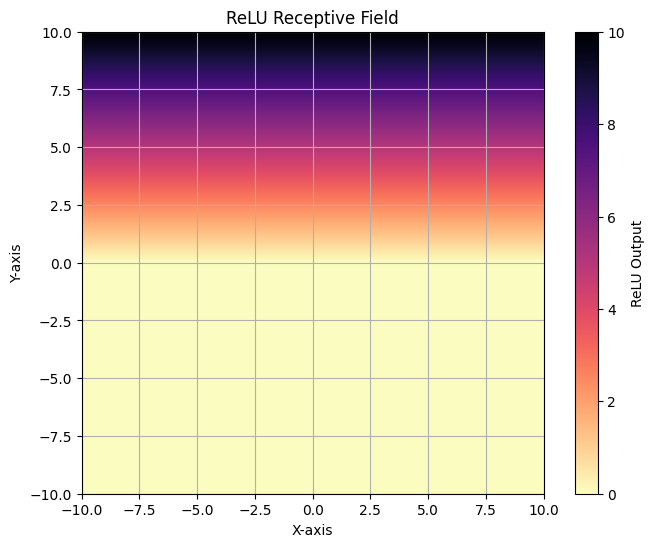

In [3]:
# Make A ReLU receptive field : plot the x - y axis, with a color gradient (e.g. magma colormap)
import numpy as np
import matplotlib.pyplot as plt
def plot_relu_receptive_field(size=10, step=0.1):
    x = np.arange(-size, size + step, step)
    y = np.arange(-size, size + step, step)
    X, Y = np.meshgrid(x, y)
    
    Z = np.maximum(0, Y)  # Example ReLU function: f(x, y) = max(0, x + y)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(Z, extent=(-size, size, -size, size), origin='lower', cmap='magma_r')
    plt.colorbar(label='ReLU Output')
    plt.title('ReLU Receptive Field')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid()
    plt.show()
plot_relu_receptive_field(size=10, step=0.1)

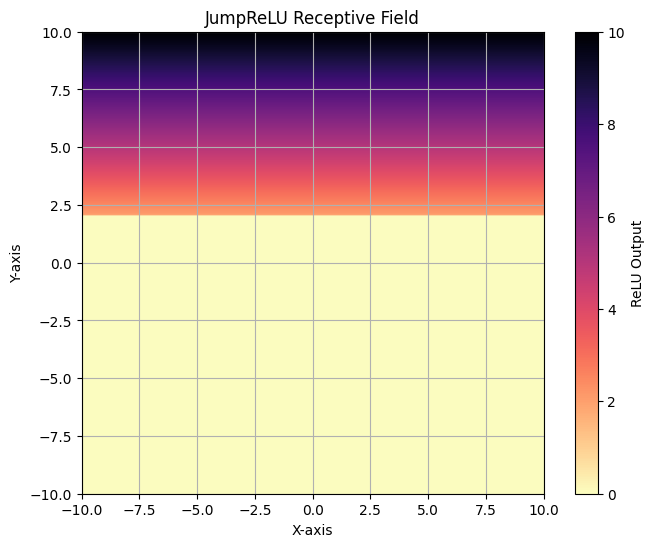

In [8]:
# Make A ReLU receptive field : plot the x - y axis, with a color gradient (e.g. magma colormap)
import numpy as np
import matplotlib.pyplot as plt
def plot_jump_relu_receptive_field(size=10, step=0.1):
    x = np.arange(-size, size + step, step)
    y = np.arange(-size, size + step, step)
    X, Y = np.meshgrid(x, y)
    
    Z = np.maximum(0, Y)  # Example ReLU function: f(x, y) = max(0, x + y)
    # JumpRelu : cut out values below a certain threshold :
    tau = 2
    Z[Z < tau] = 0  # Apply the thresholding for JumpReLU
    
    plt.figure(figsize=(8, 6))
    plt.imshow(Z, extent=(-size, size, -size, size), origin='lower', cmap='magma_r')
    plt.colorbar(label='ReLU Output')
    plt.title('JumpReLU Receptive Field')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid()
    plt.show()
plot_jump_relu_receptive_field(size=10, step=0.1)

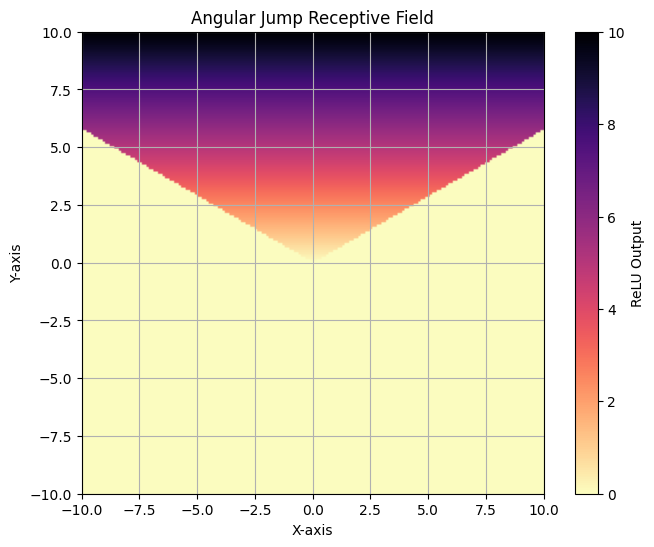

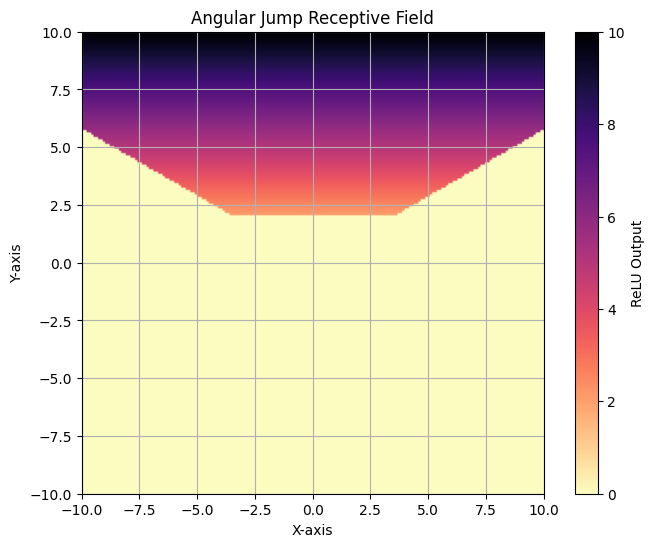

In [13]:
# Make A ReLU receptive field : plot the x - y axis, with a color gradient (e.g. magma colormap)
import numpy as np
import matplotlib.pyplot as plt
def plot_angular_jump_relu_receptive_field(size=10, step=0.1, tau=2, tau2=0.5):
    x = np.arange(-size, size + step, step)
    y = np.arange(-size, size + step, step)
    X, Y = np.meshgrid(x, y)
    
    Z = np.maximum(0, Y)  # Example ReLU function: f(x, y) = max(0, x + y)
    # JumpRelu : cut out values below a certain threshold :
    Z[Z < tau] = 0  # Apply the thresholding for JumpReLU
    # angular jump : cut out values where the cosim between (x, y) and (0, 1) is below a certain threshold
    angles = np.arctan2(X, Y)
    cos_sim = np.cos(angles)
    Z[cos_sim < tau2] = 0  # Apply the angular thresholding
    
    plt.figure(figsize=(8, 6))
    plt.imshow(Z, extent=(-size, size, -size, size), origin='lower', cmap='magma_r')
    plt.colorbar(label='ReLU Output')
    plt.title('Angular Jump Receptive Field')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid()
    plt.show()
plot_angular_jump_relu_receptive_field(size=10, step=0.1, tau=0)
plot_angular_jump_relu_receptive_field(size=10, step=0.1, tau=2)